In [25]:
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

In [2]:
'''
File path to data of participants' response with human label (score) i.e. desired[1] and desired[0]
'''
dataFile = 'D:/NLP_Data/Data4Test.csv'

In [3]:
'''
Function cleaTestResp remove stopwords and special character from the responses 
and it returns the cleaned response in new column:[cleaned_resp]. 
Argument: rows in data[response]
Output: response text wiithout stopwords and special character
'''
def cleanTextResp (textResp):
    temp = [re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", k) for k in textResp.split("\n")]
    cleaned = ' '.join(map(str,  temp))
    
    return cleaned

In [4]:
'''
Function ballanceData  balances the number of response labeled (scored) [0] and [1]
The function will usually reduce our data set for example:
in dataFile we have 93 responses Labeled [0] and 57 responses labeled [1]
output from this functioin have 57 responses labeled [0] and 57 responses labeled [1]
Argument: data, label (or score) column name, categories of label e.g. in our context 1 and 0
Outuput: data that is balanced, i.e. an equal number of response data categorises (labels) as each label category
'''
def ballanceData(in_rawData, catColumn, cat_0, cat_1):
    x=in_rawData[catColumn].value_counts()
    
    if(x[cat_0]>x[cat_1]):
        df = in_rawData.sample(frac=1).reset_index()
        df_cat_high= df[df['Label']== cat_0]
        df_cat_low = df[df['Label']== cat_1]
        df_cat_high_downsampled = df_cat_high.sample(df_cat_low.shape[0])
        df_balanced = pd.concat([df_cat_high_downsampled, df_cat_low])
        bal_shuffled = df_balanced.sample(frac=1)
        
    if(x[cat_1]>x[cat_0]):
        df = in_rawData.sample(frac=1).reset_index()
        df_cat_high= df[df['Label']== cat_1]
        df_cat_low = df[df['Label']== cat_0]
        df_cat_high_downsampled = df_cat_high.sample(df_cat_low.shape[0])
        df_balanced = pd.concat([df_cat_high_downsampled, df_cat_low])
        bal_shuffled = df_balanced.sample(frac=1)
        
    if(x[cat_1]==x[cat_0]):
        bal_shuffled = in_rawData
        
    
    return bal_shuffled

In [5]:
'''
Function train_test_split data. Use sklearn.model_selection to split data into train and test set
Argument: remaining data after preprocessing and ballancing, splitRatio--> specify the ratio of test data
        (for example, if splitRatio=0.3 then train:test data ratio is 70:30)
'''
def splitData (remaining_rawData, splitRatio):
    X_train, X_test, y_train, y_test = train_test_split(remaining_rawData['clean_resp'],remaining_rawData["Label"],test_size=splitRatio,shuffle=True,stratify=remaining_rawData['Label'])


    return X_train, X_test, y_train, y_test

In [6]:
'''
The function used the built-in  feature extraction function in sklearn.feature_extraction.text, TfidfVectorizer.
Argument: Responses in training and test data i.e. X_train and X_test
Output:  vectorized resopnses for training and testing.
'''
def vectorize_X_train_AND_X_test(in_X_train, in_X_test):
    tfidf_vectorizer = TfidfVectorizer(use_idf=True)
    X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(in_X_train) 
    X_test_vectors_tfidf = tfidf_vectorizer.transform(in_X_test)
    
    return X_train_vectors_tfidf, X_test_vectors_tfidf

In [7]:
'''
Function trains logistic regressioin model.
Argument: vectorised X_train and X_test, the corresponding labels of X_train and X_test i.e. y_train, y_test
Output: confusion matrix, accuracy, f1, recall, model's prediction, kappa score and the model
'''
def trainLR_Model(inX_train_vectors_tfidf, inX_test_vectors_tfidf, iny_train, iny_test):
    lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
    
    lr_tfidf.fit(inX_train_vectors_tfidf, iny_train)
    
    y_predict_lr = lr_tfidf.predict(inX_test_vectors_tfidf)
    
    y_prob_lr = lr_tfidf.predict_proba(inX_test_vectors_tfidf)[:,1]
    
    report_lr = classification_report(iny_test, y_predict_lr, output_dict=True)  
    cm_lr = confusion_matrix(iny_test, y_predict_lr)
    acc_lr = accuracy_score(iny_test, y_predict_lr)
    f1_lr= f1_score(iny_test, y_predict_lr)
    recall_lr=recall_score(iny_test, y_predict_lr)
    
    y_testList = iny_test.tolist()
    
    kapaLR = cohen_kappa_score(y_predict_lr, y_testList)
    
    return cm_lr, acc_lr, f1_lr, recall_lr,y_predict_lr,kapaLR, lr_tfidf

In [8]:
'''
Function trains Naive Bayes Model.
Argument: vectorised X_train and X_test, the corresponding labels of X_train and X_test i.e. y_train, y_test
Output: confusion matrix, accuracy, f1, recall, model's prediction, kappa score and the model

'''
def trainNB_Model (inX_train_vectors_tfidf, inX_test_vectors_tfidf, iny_train, iny_test):
    nb_tfidf = MultinomialNB()

    nb_tfidf.fit(inX_train_vectors_tfidf, iny_train)
    
    y_predict_nb = nb_tfidf.predict(inX_test_vectors_tfidf)

    y_prob_nb = nb_tfidf.predict_proba(inX_test_vectors_tfidf)[:,1]

    report_nb = classification_report(iny_test, y_predict_nb, output_dict=True)
    
    cm_nb = confusion_matrix(iny_test, y_predict_nb)
    acc_nb = accuracy_score(iny_test, y_predict_nb)
    f1_nb= f1_score(iny_test, y_predict_nb)
    recall_nb =recall_score(iny_test, y_predict_nb)
    
    y_testList = iny_test.tolist()
    
    kapaNB = cohen_kappa_score(y_predict_nb, y_testList)

    return cm_nb, acc_nb, f1_nb, recall_nb,y_predict_nb, kapaNB,  nb_tfidf

In [9]:
'''
Function trains logistic SVM model.
Argument: vectorised X_train and X_test, the corresponding labels of X_train and X_test i.e. y_train, y_test
Output: confusion matrix, accuracy, f1, recall, model's prediction, kappa score and the model
'''
def trainSVM_Model(inX_train_vectors_tfidf,inX_test_vectors_tfidf, iny_train, iny_test):
    SVM = svm.SVC(C=1.0, kernel = 'linear', degree=3, gamma='auto')
    SVM=svm.SVC(probability=True)
    SVM.fit(inX_train_vectors_tfidf, iny_train)
    
    y_predict_svm = SVM.predict(inX_test_vectors_tfidf)
    y_prob_svm = SVM.predict_proba(inX_test_vectors_tfidf)

    #y_prob = nb_tfidf.predict_proba(In_X_test_vectors_tfidf)[:,1]
    report_svm = classification_report(iny_test, y_predict_svm, output_dict=True)
    
    cm_svm = confusion_matrix(iny_test, y_predict_svm)
    acc_svm = accuracy_score(iny_test, y_predict_svm)
    f1_svm= f1_score(iny_test, y_predict_svm)
    
    recall_svm=recall_score(iny_test, y_predict_svm)
    
    y_testList = iny_test.tolist()
    
    kapaSVM = cohen_kappa_score(y_predict_svm, y_testList)
    
    return cm_svm, acc_svm, f1_svm, recall_svm, y_predict_svm, kapaSVM, SVM

In [10]:
'''
Function that train all the model and store the outpu metrics in a dictionary  with model name as key
e.g. resultDictionary = {"LR": Result from LR model, "NB": Result from Naive Bayes Model, "SVM": Result from SVM model}
Argument: path to data of partcpants' responses and human label 
Output: resultDictonary
'''
def trainModel_Without_Selecting_TrainingSet (in_dataFile):
    data = pd.read_csv (in_dataFile, encoding='ISO-8859-1')
    
    data['clean_resp'] = data.apply(lambda row: cleanTextResp(row['Response']), axis=1)
    
    data = ballanceData(data, 'Label', 0, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(data['clean_resp'],data["Label"],test_size=0.3,shuffle=True,stratify=data['Label'])
    
    X_train_vectors_tfidf, X_test_vectors_tfidf = vectorize_X_train_AND_X_test(X_train, X_test)
    
    lrResult = trainLR_Model(X_train_vectors_tfidf, X_test_vectors_tfidf, y_train, y_test)
    
    nbResult = trainNB_Model (X_train_vectors_tfidf, X_test_vectors_tfidf, y_train, y_test)
    
    svmResult = trainSVM_Model(X_train_vectors_tfidf, X_test_vectors_tfidf, y_train, y_test)
    
    dictResult = {'LR': lrResult, 'NB': nbResult, 'SVM': svmResult}
    
    return dictResult

In [11]:
'''
How to run the function to train model in a single run
'''
Result = trainModel_Without_Selecting_TrainingSet (dataFile)

In [13]:
'''
Run trainModel_Without_Selecting_TrainingSet (in_dataFile) in 10 iteratoins.
Collect the result from each run in a list --> Result_10Run_List
'''
Result_10Run_List=[]
for i in range(10):
    Result = trainModel_Without_Selecting_TrainingSet (dataFile)
    Result_10Run_List.append(Result)
    

In [14]:
lr_acc, lr_kappa= [],[]
nb_acc, nb_kappa= [],[]
svm_acc, svm_kappa= [],[]

In [15]:
'''
Collect the accuracy and kappa score of each model in each iteration in the above-initialized lists.
'''
for i in range(10):
    lr_acc.append(Result_10Run_List[i]['LR'][1])
    lr_kappa.append(Result_10Run_List[i]['LR'][5])
    nb_acc.append(Result_10Run_List[i]['NB'][1])
    nb_kappa.append(Result_10Run_List[i]['NB'][5])
    svm_acc.append(Result_10Run_List[i]['SVM'][1])
    svm_kappa.append(Result_10Run_List[i]['SVM'][5])

In [17]:
accuracyDict = {'Logistic Reg.': lr_acc, 'Naive Bayes': nb_acc, 'SVM': svm_acc}
accuracyData = pd.DataFrame(accuracyDict)
accuracyData.head(10)

,Logistic Reg.,Naive Bayes,SVM
0,0.771429,0.714286,0.742857
1,0.628571,0.628571,0.628571
2,0.742857,0.771429,0.742857
3,0.828571,0.771429,0.714286
4,0.800000,0.771429,0.714286
5,0.657143,0.685714,0.742857
6,0.714286,0.742857,0.685714
7,0.742857,0.742857,0.771429
8,0.657143,0.628571,0.714286
9,0.742857,0.685714,0.771429


In [22]:
accuracyData.max()

Logistic Reg.    0.828571
Naive Bayes      0.771429
SVM              0.771429
dtype: float64

In [23]:
kapaDict = {'Logistic Reg.': lr_kappa, 'Naive Bayes': nb_kappa, 'SVM': svm_kappa}
kappaData = pd.DataFrame(kapaDict)
kappaData.head(10)

,Logistic Reg.,Naive Bayes,SVM
0,0.540984,0.429967,0.484452
1,0.262561,0.262561,0.260163
2,0.484452,0.543974,0.484452
3,0.657980,0.543974,0.435484
4,0.600326,0.542484,0.431818
5,0.304636,0.363636,0.481054
6,0.428105,0.484452,0.371941
7,0.489465,0.491115,0.545455
8,0.311475,0.255319,0.429967
9,0.487805,0.380032,0.545455


In [24]:
kappaData.max()

Logistic Reg.    0.657980
Naive Bayes      0.543974
SVM              0.545455
dtype: float64

Text(0.5, 1.0, 'Accuracy of model in 10 runs radomly spliting Training:Test data')

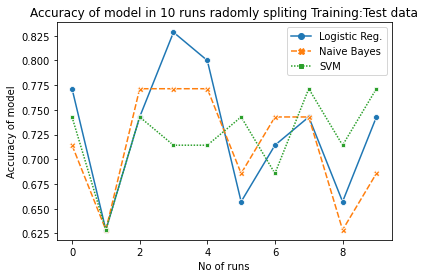

In [26]:
sns.lineplot(data=accuracyData, markers=True)
plt.xlabel("No of runs")
plt.ylabel("Accuracy of model")
plt.title("Accuracy of model in 10 runs radomly spliting Training:Test data")

Text(0.5, 1.0, 'Kappa value of model in 10 runs radomly spliting Training:Test data')

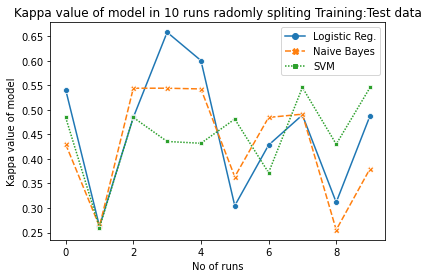

In [27]:
sns.lineplot(data=kappaData, markers=True)
plt.xlabel("No of runs")
plt.ylabel("Kappa value of model")
plt.title("Kappa value of model in 10 runs radomly spliting Training:Test data")